In [23]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

# Make the VF Solution and use it as input to network

import sys
sys.path.insert(0,'..')
import VF.vectorfit

In [24]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# 1. Load the data and get measurements

In [25]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 6

In [26]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [27]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [28]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 501)
GT S-parameters shape:  (10, 2, 501)
Y S-parameters shape:  (10, 2, 20)


In [29]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (501,)
Y frequencies shape:  (20,)


In [30]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  10.0
Mean frequency spacing:  39999999.98
STD frequency spacing:  0.4467661580737738
Mode frequency spacing:  40000000.0
Number of samples with non-equal spacing:  2


In [31]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [32]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  501
N_SPARAMS:  10


In [33]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 501])


In [34]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 501])


## Plot some stuff

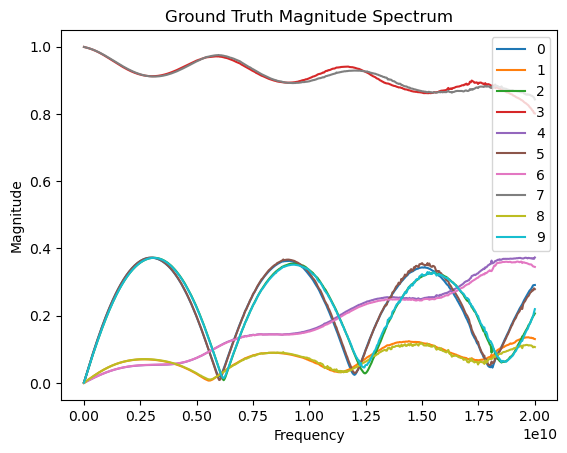

In [35]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

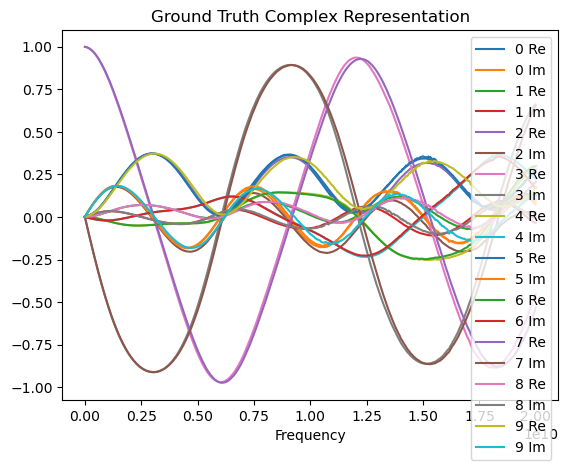

In [36]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [37]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 20

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  501
Number of Measurements:  20
Undersampling Ratio:  0.03992015968063872
[  0  26  78 131 184 236 289 342 394 447 500]
[  0  26  52  78 105 131 157 184 210 236 263 289 315 342 368 394 421 447
 473 500]


In [38]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 11])
y_freqs shape:  (11,)


# 2. Network Setup

## Define network parameters

In [39]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [40]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  5
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [41]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [42]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 501])


In [43]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  283848


# 3. Run

## Define training parameters, losses, and track stats

In [44]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
CURR_ITER = FIRST_ITER
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

print("NUM ACTIVE: ", NUM_ACTIVE)

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        LENGTH_GT = len(gt_freqs)
        cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
        fname = os.path.join(ROOT_PATH, "case"+cn)

        children = os.listdir(fname)
        children = [f for f in children if cn + ".s" in f]

        final_path = os.path.join(fname, children[0])

        fitter = VF.vectorfit.VectorFitter(final_path)
        fit1 = fitter.vector_fit("VF Result", y_freqs) 
        vf_output = fit1.fitted_network.s

        vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
        vf_data = utils.matrix_to_sparams(vf_data)
        vf_data = torch.tensor(vf_data).view(1, -1, LENGTH_GT)
        vf_data = vf_data.to(device)

        
        # Find the maximum standard deviation point, and use it to update kept_inds
        print(sgld_outputs_by_sample)
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], vf_data, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]


    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)


    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(outputs, vf_outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(vf_outputs.shape)
        print(outputs.shape)
        sqr_differences = torch.square(torch.subtract(vf_outputs[0], outputs))

        # Sum to go to [1000]
        sqr_differences = torch.mean(sqr_differences, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(sqr_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(sqr_differences, len(sqr_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


NUM ACTIVE:  9
ITER  0
TIME:  2.008005380630493
NOISE LEVEL:  0.9998182334878771

ITER  999
TIME:  20.48838186264038
NOISE LEVEL:  0.8337822234718045

ITER  1999
TIME:  38.04385733604431
NOISE LEVEL:  0.6951927961775853

ITER  2999
TIME:  55.83065605163574
NOISE LEVEL:  0.5796393953385278

ITER  3999
TIME:  73.72474813461304
NOISE LEVEL:  0.4832930238572089

ITER  4999
TIME:  91.34612011909485
NOISE LEVEL:  0.40296113202007533

ITER  5999
TIME:  108.93645095825195
NOISE LEVEL:  0.33598182862841364

ITER  6999
TIME:  126.69856333732605
NOISE LEVEL:  0.28013567611992135

ITER  7999
TIME:  144.970853805542
NOISE LEVEL:  0.2335721469090449

ITER  8999
TIME:  163.18066596984863
NOISE LEVEL:  0.1947483039909062

ITER  9999
TIME:  181.19116616249084
NOISE LEVEL:  0.16237767391890093

ITER  10999
TIME:  199.64426612854004
NOISE LEVEL:  0.1353876180022807

ITER  11999
TIME:  218.25583362579346
NOISE LEVEL:  0.11288378916849302

ITER  12999
TIME:  236.75252056121826
NOISE LEVEL:  0.0941204967268

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.15660578198730946 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.005808832181926061 vs 0.04321709714233492)
Fit completed in 0.26442790031433105, using 3, resulting in a fit with 5 and error=0.005808832181926061 vs samples and error=0.0075240449762578945 vs ground truth.
[tensor([[[ 5.3625e-02,  5.2548e-02,  4.3433e-02,  ...,  8.7854e-02,
           9.2176e-02,  1.0093e-01],
         [-7.2447e-04, -6.2300e-03, -7.2898e-03,  ..., -5.8666e-02,
          -5.1846e-02, -5.0945e-02],
         [ 9.2265e-02,  9.2111e-02,  8.1277e-02,  ...,  2.8128e-02,
           3.3473e-02,  4.2712e-02],
         ...,
         [-1.5317e-03, -2.5828e-03, -4.4780e-03,  ...,  1.1632e-01,
           1.1861e-01,  1.2421e-01],
         [ 2.1071e-02,  1.8708e-02,  2.4011e-02,  ...,  1.0329e-01,
           1.0866e-01,  1.2025e-01],
         [ 4.1314e-04,  7.5912e-03,  1.2999e-02,  ..., -1.0324e-01,
          -9.2779e-02, -9

In [45]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([455, 20, 501])
torch.Size([20, 501])
torch.Size([20, 501])


## Plot metrics and outputs

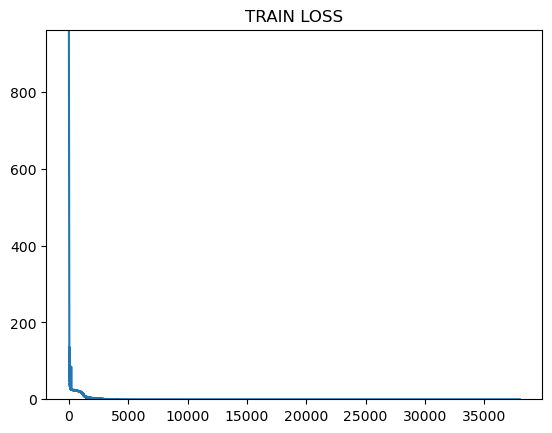

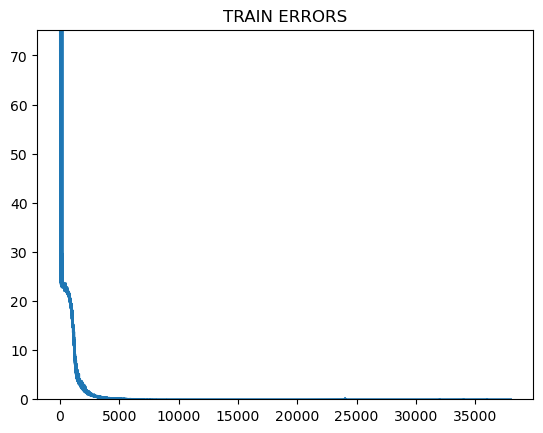

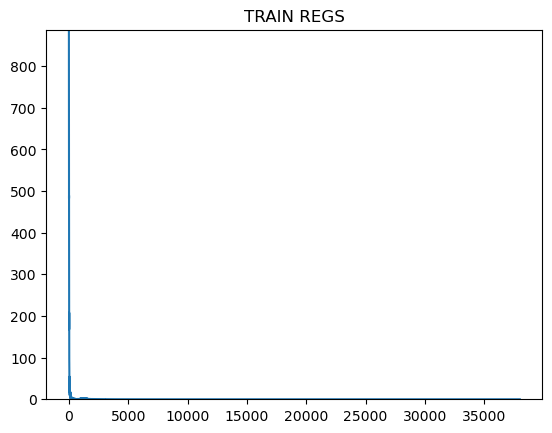

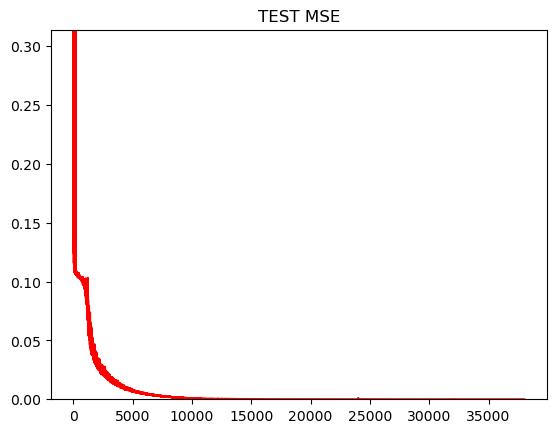

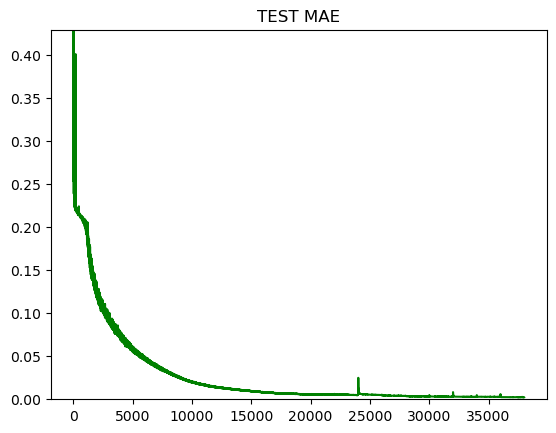

In [46]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [47]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  1.3212088560976554e-05
Best Test MSE:  1.302352666243678e-05
Best Test MSE Iteration:  37913


In [48]:
LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case06/case06.s4p
[1.00000000e+01 1.04000001e+09 2.04000001e+09 3.12000001e+09
 4.24000001e+09 5.24000001e+09 7.36000001e+09 8.32000001e+09
 9.44000001e+09 1.15600000e+10 1.26400000e+10 1.36800000e+10
 1.57600000e+10 1.67600000e+10 1.78400000e+10 1.78800000e+10
 1.91600000e+10 1.94800000e+10 1.99600000e+10 2.00000000e+10]
Performing fit with 1 poles.
  Fitting took 0.017707617953419685 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.027899473905563354 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 0.04967489805404023 vs 0.04756773861883883)
Performing fit with 3 poles.
  Fitting took 0.20483940094709396 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 2 (err 0.004152976408454506 vs 0.04756773861883883)
P

In [49]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([501, 4, 4, 2])
torch.Size([501, 4, 4, 2])
torch.Size([20, 4, 4, 2])
(501, 4, 4, 2)
(501, 4, 4, 2)
(10, 2, 501)
(10, 2, 501)
float32
float32
DIP PSNR:       54.8108843948725
VF PSNR:        55.4576246018926
Final DIP MSE:  1.3212088560976554e-05
VF MSE:         1.1384069694031496e-05
Mean DIP MSE:  1.371264170302311e-05


(501,)
torch.Size([20, 501])
torch.Size([1, 20, 501])
torch.Size([1, 20, 20])
torch.Size([1, 20, 501])
torch.Size([1, 20, 501])


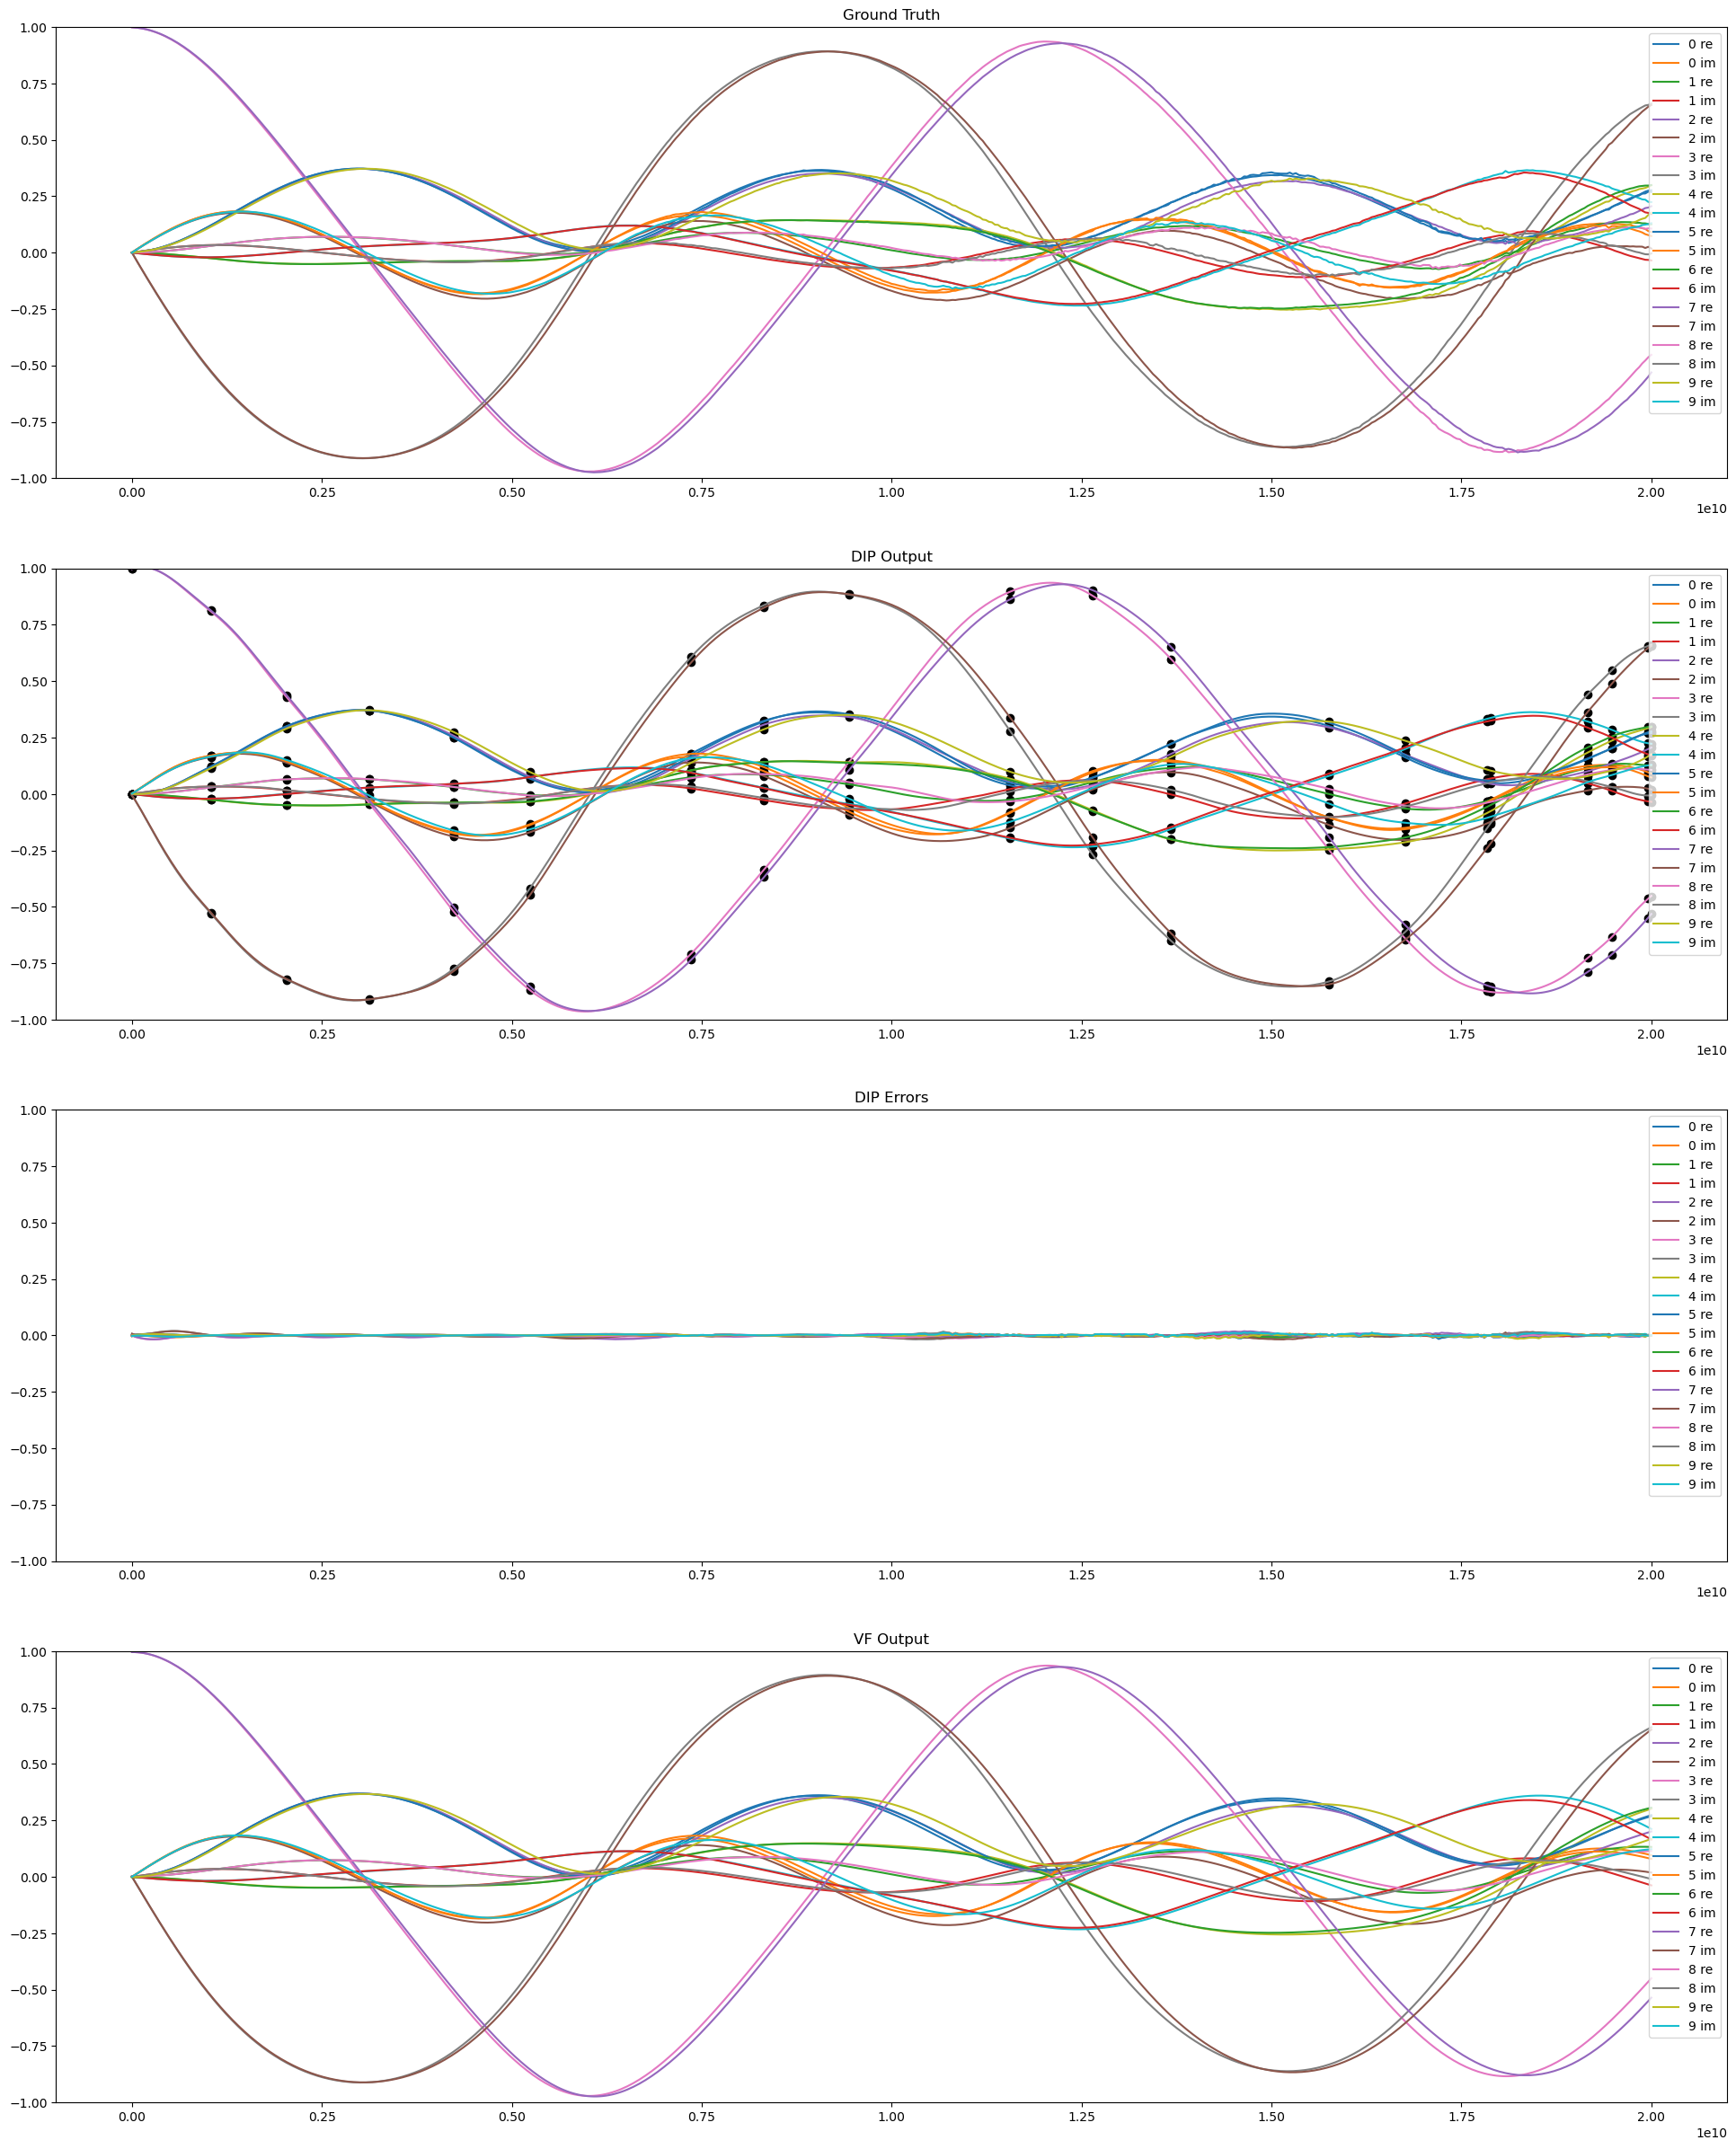

In [55]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [51]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[4.7959e-04, 4.7675e-04, 4.6294e-04, 4.5994e-04, 4.6671e-04, 4.7781e-04,
         4.9320e-04, 4.9857e-04, 4.9364e-04, 4.7592e-04, 4.4634e-04, 4.3690e-04,
         4.2978e-04, 4.3154e-04, 4.2536e-04, 2.7145e-04, 2.1757e-04, 3.0301e-04,
         2.7277e-04, 2.1289e-04, 1.3467e-04, 8.3356e-05, 7.4506e-05, 1.1448e-04,
         1.8159e-04, 2.2316e-04, 2.5429e-04, 2.6211e-04, 2.1507e-04, 3.1058e-04,
         3.4473e-04, 3.6582e-04, 3.6471e-04, 3.2571e-04, 3.0513e-04, 2.8117e-04,
         2.4308e-04, 2.1242e-04, 2.5925e-04, 2.3801e-04, 1.7759e-04, 1.3836e-04,
         1.5722e-04, 1.8118e-04, 2.0936e-04, 2.1909e-04, 2.4260e-04, 2.6319e-04,
         2.5906e-04, 2.5897e-04, 3.5720e-04, 4.3229e-04, 4.6679e-04, 4.5644e-04,
         3.9167e-04, 3.1807e-04, 2.4424e-04, 1.9233e-04, 1.5726e-04, 1.5819e-04,
         1.6101e-04, 1.6305e-04, 1.6609e-04, 1.6449e-04, 2.1454e-04, 2.4005e-04,
         2.3615e-04, 2.1636e-04, 1.8059e-04, 1.5626e-04, 1.4386e-04, 1.3578e-04,
         1.3270e-04, 1.0917e

In [52]:
print(dip_errors[-1])

tensor([[-1.0850e-04,  2.5313e-03,  4.0113e-03,  5.1849e-03,  6.0738e-03,
          6.6983e-03,  7.0507e-03,  7.1389e-03,  6.9542e-03,  6.5924e-03,
          6.0489e-03,  5.4074e-03,  4.5300e-03,  3.6193e-03,  2.6410e-03,
          1.7517e-03,  8.4101e-04, -4.4096e-05, -7.3593e-04, -1.2514e-03,
         -1.5975e-03, -1.8246e-03, -1.8886e-03, -1.7828e-03, -1.5210e-03,
         -1.1342e-03, -6.2733e-04,  4.4122e-05,  6.0181e-04,  1.0686e-03,
          1.5422e-03,  1.9552e-03,  2.2836e-03,  2.5548e-03,  2.7158e-03,
          2.7230e-03,  2.5694e-03,  2.4061e-03,  2.0840e-03,  1.7585e-03,
          1.4344e-03,  1.1001e-03,  7.7239e-04,  4.7058e-04,  1.7375e-04,
         -6.3121e-05, -2.7490e-04, -4.4245e-04, -5.0023e-04, -4.5416e-04,
         -4.0284e-04, -2.4787e-04, -4.2409e-05,  2.1002e-04,  5.3325e-04,
          8.6775e-04,  1.2024e-03,  1.5164e-03,  1.8477e-03,  2.1411e-03,
          2.3791e-03,  2.5779e-03,  2.7386e-03,  2.9280e-03,  3.0334e-03,
          3.0187e-03,  2.9566e-03,  2.

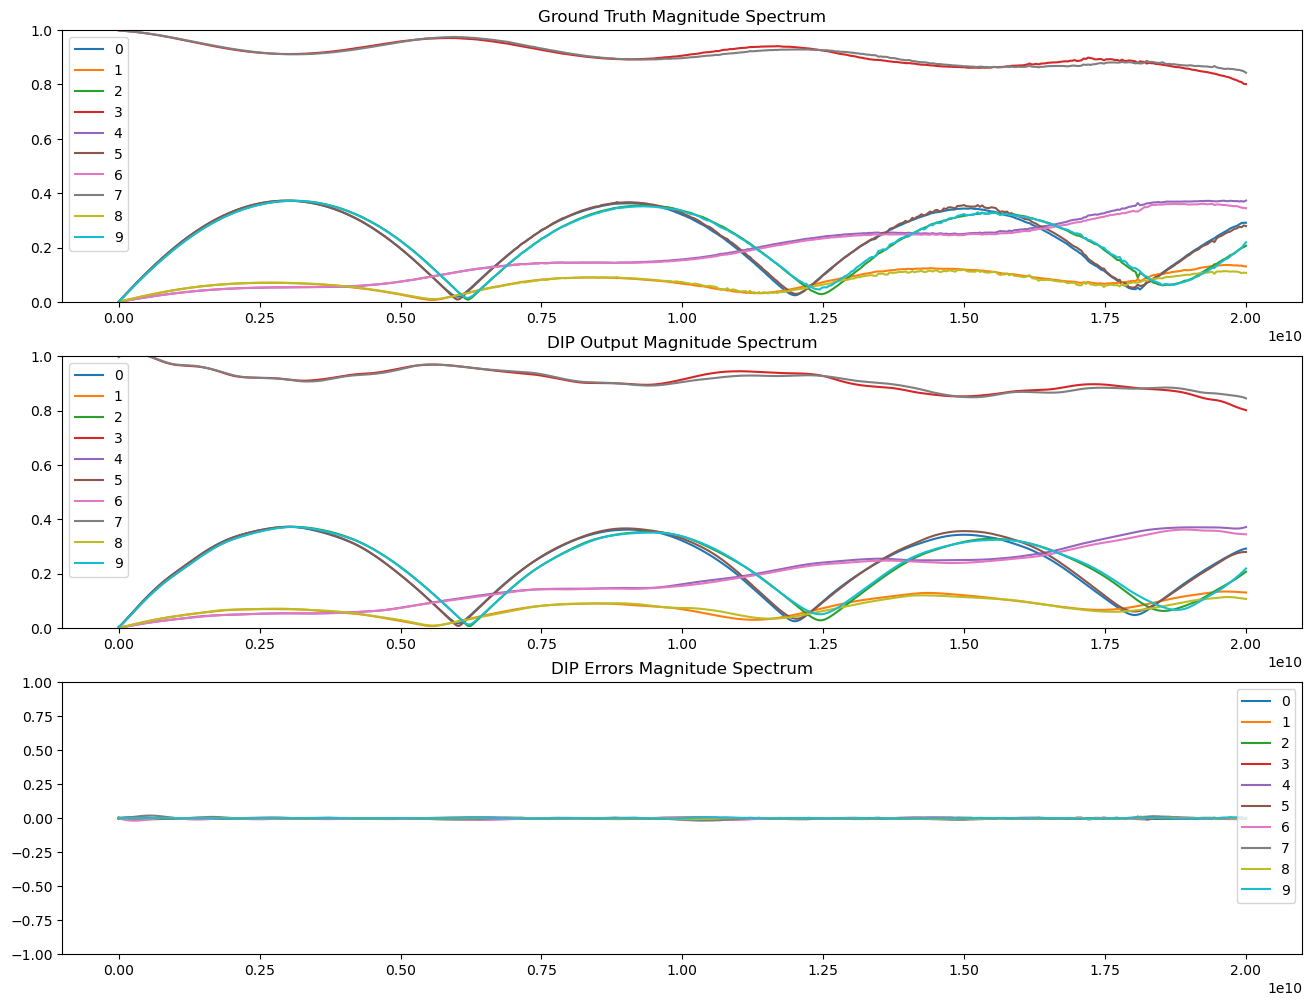

In [53]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [54]:
print(kept_inds)

[  0  26  51  78 106 131 184 208 236 289 316 342 394 419 446 447 479 487
 499 500]
